In [80]:
import deltaRCM_base
reload(deltaRCM_base)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

class deltaRCM(deltaRCM_base.Tools):

    _input_vars = {
        'model_output__site_prefix': {'name':'site_prefix', 'type': 'string', 'default': ''},
        'model_output__case_prefix': {'name':'case_prefix', 'type': 'string', 'default': ''},
        'model_output__out_dir': {'name':'out_dir', 'type': 'string', 'default': 'deltaRCM_Output/'},
        'model__total_timesteps': {'name':'n_steps', 'type': 'long', 'default': 200},
        'model_grid__length': {'name':'Length', 'type': 'float', 'default': 5000.},
        'model_grid__width': {'name':'Width', 'type': 'float', 'default': 10000.},
        'model_grid__cell_size': {'name':'dx', 'type': 'float', 'default': 100.},
        'land_surface__width': {'name':'L0_meters', 'type': 'float', 'default': 300.}, 
        'land_surface__slope': {'name':'S0', 'type': 'float', 'default': 0.00015},
        'model__max_iteration': {'name':'itermax', 'type': 'long', 'default': 1},
        'water__number_parcels': {'name':'Np_water', 'type': 'long', 'default': 1000},
        'channel__flow_velocity': {'name':'u0', 'type': 'float', 'default': 1.},
        'channel__width': {'name':'N0_meters', 'type': 'float', 'default': 300.},
        'channel__flow_depth': {'name':'h0', 'type': 'float', 'default': 5.},
        'sea_water_surface__mean_elevation': {'name':'H_SL', 'type': 'float', 'default': 0.},
        'sea_water_surface__rate_change_elevation': {'name':'SLR', 'type': 'float', 'default': 0.},
        'sediment__number_parcels': {'name':'Np_sed', 'type': 'long', 'default': 1000},
        'sediment__bedload_fraction': {'name':'f_bedload', 'type': 'float', 'default': 0.25}, 
        'sediment__influx_concentration': {'name':'C0_percent', 'type': 'float', 'default': 0.1},                   
        'model_output__opt_eta_figs': {'name':'save_eta_figs', 'type': 'choice', 'default': True},
        'model_output__opt_stage_figs': {'name':'save_stage_figs', 'type': 'choice', 'default': False},
        'model_output__opt_depth_figs': {'name':'save_depth_figs', 'type': 'choice', 'default': False},
        'model_output__opt_eta_grids': {'name':'save_eta_grids', 'type': 'choice', 'default': False},
        'model_output__opt_stage_grids': {'name':'save_stage_grids', 'type': 'choice', 'default': False},
        'model_output__opt_depth_grids': {'name':'save_depth_grids', 'type': 'choice', 'default': False},
        'model_output__opt_time_interval': {'name':'save_dt', 'type': 'long', 'default': 50},
        'coeff__surface_smoothing': {'name': 'Csmooth', 'type': 'float', 'default': 0.9},
        'coeff__under_relaxation__water_surface': {'name': 'omega_sfc', 'type': 'float', 'default': 0.1},
        'coeff__under_relaxation__water_flow': {'name': 'omega_flow', 'type': 'float', 'default': 0.9},
        'coeff__iterations_smoothing_algorithm': {'name': 'Nsmooth', 'type': 'long', 'default': 5},
        'coeff__depth_dependence__water': {'name': 'theta_water', 'type': 'float', 'default': 1.0},
        'coeff__depth_dependence__sand': {'name': 'coeff_theta_sand', 'type': 'float', 'default': 2.0},
        'coeff__depth_dependence__mud': {'name': 'coeff_theta_mud', 'type': 'float', 'default': 1.0},
        'coeff__non_linear_exp_sed_flux_flow_velocity': {'name': 'beta', 'type': 'long', 'default': 3},
        'coeff__sedimentation_lag': {'name': 'sed_lag', 'type': 'float', 'default': 1.0},
        'coeff__velocity_deposition_mud': {'name': 'coeff_U_dep_mud', 'type': 'float', 'default': 0.3},
        'coeff__velocity_erosion_mud': {'name': 'coeff_U_ero_mud', 'type': 'float', 'default': 1.5},
        'coeff__velocity_erosion_sand': {'name': 'coeff_U_ero_sand', 'type': 'float', 'default': 1.05},
        'coeff__topographic_diffusion': {'name': 'alpha', 'type': 'float', 'default': 0.1},
        'basin__opt_subsidence': {'name':'toggle_subsidence', 'type': 'choice', 'default': False},
        'basin__maximum_subsidence_rate': {'name': 'sigma_max', 'type': 'float', 'default': 0.000825},
        'basin__subsidence_start_timestep': {'name': 'start_subsidence', 'type': 'long', 'default': 0},
        'basin__opt_stratigraphy': {'name': 'save_strata', 'type': 'choice', 'default': False}
        }


    #############################################
    ################### update ##################
    #############################################

    def update(self):
        '''
        Run the model for one full instance
        '''

        for timestep in range(self.n_steps):
            self.run_one_timestep(timestep)
            
            self.apply_subsidence(timestep)
            self.record_stratigraphy(timestep)
            
            self.finalize_timestep(timestep)
            self.output_data(timestep)
        
        
        ##### finalize #####
        self.output_strata()
        
        try:
            self.output_netcdf.close()
            if self.verbose: print 'Closed output netcdf file.'
        except:
            pass



    #############################################
    ################## __init__ #################
    #############################################

    def __init__(self):
        '''
        Creates an instance of the model

        Sets the most commonly changed variables here
        Calls functions to set the rest and create the domain (for cleanliness)
        '''
        
        self.verbose = True
        self.input_file = 'deltaRCM.yaml'
        
        self.create_dicts()
        self.set_defaults()
        self.import_file()
        
        self.create_other_variables()
        self.create_domain()
        
        
        self.init_subsidence()
        self.init_stratigraphy()
        self.init_output_grids()




delta = deltaRCM()
delta.update()




Reading input file...
Finished reading 30 variables from input file.
Generating netCDF file for output grids...
*** Replaced existing netCDF file ***
Output netCDF file created.
--------------------
Time = 1 of 10
Applying subsidence
Storing stratigraphy data
--------------------
Time = 2 of 10
Applying subsidence
Storing stratigraphy data
Saving grid: eta
--------------------
Time = 3 of 10
Applying subsidence
Storing stratigraphy data
--------------------
Time = 4 of 10
Applying subsidence
Storing stratigraphy data
Saving grid: eta
--------------------
Time = 5 of 10
Applying subsidence
Storing stratigraphy data
--------------------
Time = 6 of 10
Applying subsidence
Storing stratigraphy data
Saving grid: eta
--------------------
Time = 7 of 10
Applying subsidence
Storing stratigraphy data
--------------------
Time = 8 of 10
Applying subsidence
Storing stratigraphy data
Saving grid: eta
--------------------
Time = 9 of 10
Applying subsidence
Storing stratigraphy data
----------------

In [14]:
sf = delta.strata_sand_frac[:,0].toarray().reshape(delta.eta.shape)
sf[sf == 0] = -1

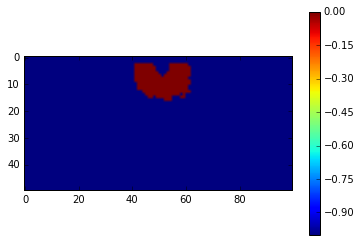

In [79]:
plt.imshow(sf)
plt.colorbar()

In [78]:
delta.out_dir[-1] is not '/'

True

In [43]:
shape = delta.strata_eta.shape



# total_strata_age = delta.output_netcdf.createDimension('total_strata_age', shape[1])


strata_age = delta.output_netcdf.createVariable('strata_age',np.int32,('total_strata_age'))
strata_age.units = 'timesteps'

# sand_frac = delta.output_netcdf.createVariable('strata_sand_frac',
#                                               np.float32,
#                                               ('strata_age','length','width'))
# sand_frac.units = 'fraction'

# strata_elev = delta.output_netcdf.createVariable('strata_depth',
#                                               np.float32,
#                                               ('strata_age','length','width'))
# strata_elev.units = 'meters'

delta.output_netcdf['strata_age'][:] = range(shape[1]-1, -1, -1)

for i in range(shape[1]):
    
#     sf = delta.strata_sand_frac[:,i].toarray().reshape(delta.eta.shape)
#     sf[sf == 0] = -1
    
#     delta.output_netcdf['strata_sand_frac'][i,:,:] = sf

    sf = delta.strata_sand_frac[:,i].toarray().reshape(delta.eta.shape)
    sf[sf == 0] = -1
    
    delta.output_netcdf['strata_sand_frac'][i,:,:] = sf
    
    sz = delta.strata_eta[:,i].toarray().reshape(delta.eta.shape)
    sz[sz == 0] = delta.init_eta[sz == 0]

    delta.output_netcdf['strata_depth'][i,:,:] = sz
    
    

In [26]:
sz = delta.strata_eta[:,i].toarray().reshape(delta.eta.shape)
sz[sz == 0] = delta.init_eta[sz == 0]

delta.output_netcdf['strata_depth'][i,:,:] = sz

In [55]:
len(delta._input_vars)

43

In [57]:
delta._input_var_names


['model__max_iteration',
 'channel__flow_depth',
 'basin__subsidence_start_timestep',
 'channel__width',
 'coeff__depth_dependence__water',
 'basin__maximum_subsidence_rate',
 'sediment__bedload_fraction',
 'coeff__non_linear_exp_sed_flux_flow_velocity',
 'coeff__depth_dependence__sand',
 'coeff__sedimentation_lag',
 'model__total_timesteps',
 'model_grid__cell_size',
 'sea_water_surface__elevation',
 'model_grid__width',
 'model_output__opt_stage_grids',
 'land_surface__width',
 'land_surface__slope',
 'basin__opt_stratigraphy',
 'water__number_parcels',
 'coeff__under_relaxation__water_surface',
 'coeff__iterations_smoothing_algorithm',
 'model_output__opt_eta_grids',
 'channel__flow_velocity',
 'basin__opt_subsidence',
 'model_output__opt_depth_grids',
 'model_output__opt_time_interval',
 'model_output__out_dir',
 'model_output__opt_depth_figs',
 'model_grid__length',
 'coeff__surface_smoothing',
 'model_output__opt_stage_figs',
 'coeff__under_relaxation__water_flow',
 'sea_water_su

In [58]:
vars = {'channel__flow_velocity': {'name':'u0', 'type': 'float', 'default': 1.},
'channel__width': {'name':'N0_meters', 'type': 'float', 'default': 300.},
'channel__flow_depth': {'name':'h0', 'type': 'float', 'default': 5.},
'sea_water_surface__elevation': {'name':'H_SL', 'type': 'float', 'default': 0.},
'sea_water_surface__rate_change_elevation': {'name':'SLR', 'type': 'float', 'default': 0.},
'sediment__bedload_fraction': {'name':'f_bedload', 'type': 'float', 'default': 0.25}, 
'sediment__influx_concentration': {'name':'C0_percent', 'type': 'float', 'default': 0.1}}

['u0', 'h0', 'f_bedload', 'N0_meters', 'SLR', 'H_SL', 'C0_percent']